In [21]:
import xarray as xr
from nmme_download import iri_nmme_models
# used model list
model_use_list = [
    'CanCM4i-IC3',
    'GEM5-NEMO',
    # 'GFDL-SPEAR-regridded',
    # 'NASA-GEOSS2S',
    # 'COLA-RSMAS-CCSM4',
    # 'COLA-RSMAS-CESM1',
    # 'NCEP-CFSv2'
]


dict_model = iri_nmme_models()
all_avai_model_list = list(dict_model.keys())

In [22]:
all_avai_model_list

['CanCM4i',
 'GEM-NEMO',
 'GFDL-SPEAR',
 'NASA-GEOSS2S',
 'COLA-RSMAS-CCSM4',
 'NCEP-CFSv2',
 'CanCM4i-IC3',
 'GEM5-NEMO',
 'COLA-RSMAS-CESM1',
 'GFDL-SPEAR-regridded']

In [24]:
 # directory where new simulation (inputs) and mhw forecast (outputs) is located
BASEDIR = '/Datasets.private/marinehw/nmme_sst_raw/'

# directory where sst threshold/climatology/trend (inputs) and mhw hindcast (outputs) is located
PREDIR = '/Datasets.private/marinehw/nmme_sst_stat/'

import cftime
import numpy as np
from nmme_climo import read_nmme

current_year = 2024
current_month = 5
model_list = model_use_list
all_model_list = all_avai_model_list
basedir = BASEDIR
predir = PREDIR
threshold = 90


da_nmem_list = []
da_model_list = []
da_climo_list = []
avai_model_list = []
for modelname in model_list:
    if modelname in all_model_list:

        # construct model list
        forecast_files = f'{basedir}{modelname}_forecast_??_??_??_??????.nc'
        climo_file = f'{predir}{modelname}_climo.nc'

        print('------------')
        print(modelname)
        print('------------')


        # lazy loading all dataset
        ds_nmme = read_nmme(
            forecast_files = forecast_files,
            model = modelname,
            chunks={'M':1,'L':1,'S':1}
        )

        da_model = ds_nmme['sst']

        try :
            da_model = da_model.sel(
                S=cftime.Datetime360Day(
                    current_year, current_month, 1, 0, 0, 0, 0, has_year_zero=True
                )
            )
        except KeyError:
            # if any of the date in slice does not exist, the data is fill with NaN
            da_model = da_model.isel(S=-1)*np.nan
            da_model['S'] = cftime.Datetime360Day(
                current_year, current_month, 1, 0, 0, 0, 0, has_year_zero=True
            )

        # read climatology (1991-2020)
        da_ensmean_climo = xr.open_dataset(climo_file,chunks={'S':1,'L':1})['sst']

        # calculate ensemble member in each model
        da_nmem = da_model.where(da_model.isnull(), other=1).sum(dim=['M'])
        da_nmem = da_nmem.where(da_nmem>0)

        # stored all models in one list
        da_nmem_list.append(da_nmem)           # number of ensemble member
        da_model_list.append(da_model)         # model output
        da_climo_list.append(da_ensmean_climo) # model climatology
        avai_model_list.append(modelname)

# combined all model into one dataset
da_model_all = xr.concat(
    [da for da in da_model_list if type(da) != type("string")],
    dim='model',
    join='outer'
).compute()
da_model_all['model'] = avai_model_list
da_climo_all = xr.concat(
    [da for da in da_climo_list if type(da) != type("string")],
    dim='model',
    join='outer'
).compute()
da_climo_all['model'] = avai_model_list
da_nmem_all = xr.concat(
    [da for da in da_nmem_list if type(da) != type("string")],
    dim='model',
    join='outer'
).compute()
da_nmem_all['model'] = avai_model_list
da_ensmask_all = xr.concat(
    [da for da in da_model_list if type(da) != type("string")],
    dim='model',
    join='outer'
)
da_ensmask_all['model'] = avai_model_list

da_ensmask_all = da_ensmask_all.sum(dim=['X','Y']).compute()
da_ensmask_all = da_ensmask_all.where(da_ensmask_all==0,other=1)
da_ensmask_all = da_ensmask_all.where(da_ensmask_all==1)

# create mask for every S, L, X, Y (if model number less than 2 will be masked)
da_nmodel = (da_nmem_all/da_nmem_all).sum(dim='model')
da_nmodel_mask = da_nmodel.where(da_nmodel>1)
da_allmodel_mask = da_nmodel_mask.where(da_nmodel_mask.isnull(),other=1).compute()

# calculate total member of all model
da_nmem_all_out = (da_nmem_all*da_allmodel_mask).sum(dim='model').compute()



------------
CanCM4i-IC3
------------
reading data
------------
GEM5-NEMO
------------
reading data


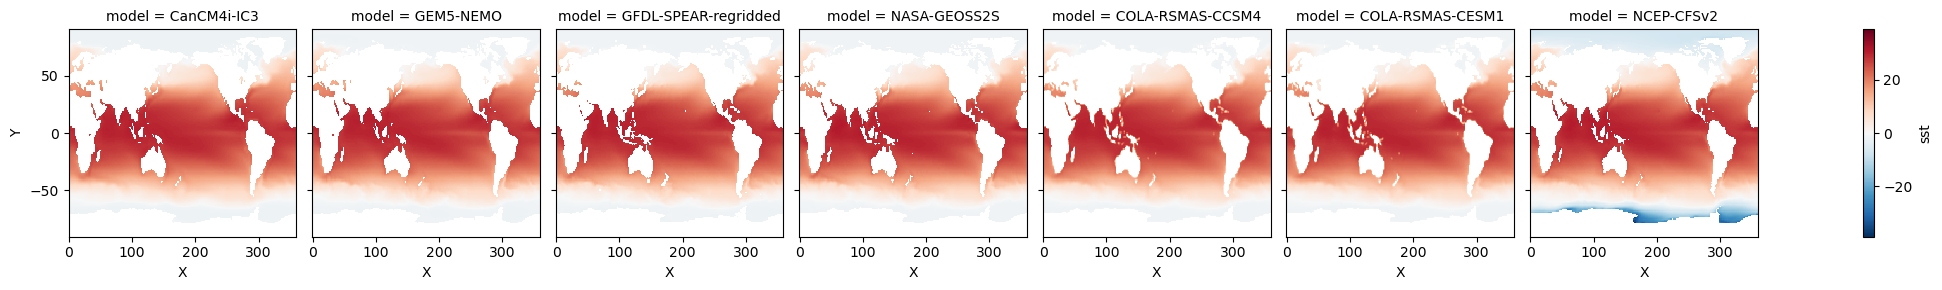

In [6]:
da_climo_all.isel(L=0,month=4).plot(col='model')

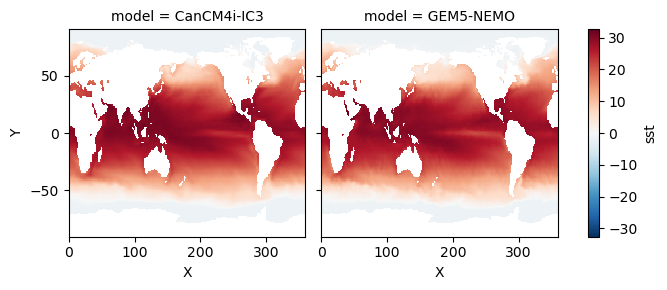

In [25]:
da_model_all.isel(L=1,M=1).plot(col='model')

In [ ]:

# loop through all set threshold
m = threshold
da_mhw_list = []
da_anom_list = []
da_mhw_anom_list = []
avai_model_list = []
for modelname in model_list:
    if modelname in all_model_list:

        # construct model file
        threshold_file = f'{predir}{modelname}_threshold{m}.nc'

        print('------------')
        print(modelname,' MHW detection...')
        print('------------')

        # read threshold (1991-2020)
        da_threshold = xr.open_dataset(
            threshold_file,
            chunks={'S':1,'L':1}
        )[f'threshold_{m}']

        print('calculating anomaly')
        month = da_model_all.sel(model=modelname)['S.month'].data
        da_anom = da_model_all.sel(model=modelname) - da_climo_all.sel(model=modelname).sel(month=month)
        da_anom_list.append(da_anom)
        avai_model_list.append(modelname)

        print('calculating MHW')
        month = da_anom.month.data
        da_mhw_temp = da_anom.where(da_anom>=da_threshold.sel(month=month))
        da_mhw_anom_list.append(da_mhw_temp)
        da_mhw = (da_mhw_temp
                    .where(da_mhw_temp.isnull(),other=1)
                    .sum(dim='M',skipna=True)
        )
        da_mhw_list.append(da_mhw)

da_anom_list = [da for da in da_anom_list if type(da) != type("string")]
da_mhw_anom_list = [da for da in da_mhw_anom_list if type(da) != type("string")]
da_mhw_list = [da for da in da_mhw_list if type(da) != type("string")]

da_anom_all = xr.concat(da_anom_list,dim='model',join='outer')
da_anom_all['model'] = avai_model_list

da_mhw_anom_all = xr.concat(da_mhw_anom_list,dim='model',join='outer')
da_mhw_anom_all['model'] = avai_model_list

da_mhw_all = xr.concat(da_mhw_list,dim='model',join='outer')
da_mhw_all_out = (da_mhw_all*da_allmodel_mask).sum(dim='model').compute()
da_mhw_prob = (da_mhw_all_out/da_nmem_all_out)*da_allmodel_mask